In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
dateparse = lambda x, y: datetime.strptime(str(x)+str(y), '%d:%m:%Y%H:%M:%S')

# Level 1.0

In [2]:
url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=Lake_Okeechobee_N&year=2021&month=1&day=1&year2=2021&month2=8&day2=30&LWN10=1&AVG=10'
df = pd.read_csv(url, skiprows=7, skipfooter=1, parse_dates={'datetime': ['Date(dd-mm-yyyy)','Time(hh:mm:ss)']},
                 date_parser=dateparse, engine='python')
df.set_index('datetime', inplace=True)

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/pandas/io/parsers.py:3339: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


# Level 1.5

In [3]:
url2 = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?site=Lake_Okeechobee_N&year=2021&month=1&day=1&year2=2021&month2=8&day2=29&LWN15=1&AVG=10'
df2 = pd.read_csv(url2, skiprows=7, skipfooter=1, parse_dates={'datetime': ['Date(dd-mm-yyyy)','Time(hh:mm:ss)']},
                 date_parser=dateparse, engine='python')
df2.set_index('datetime', inplace=True)

# F0 [Thuillier (2003) solar spectrum]

<AxesSubplot:xlabel='wavelength'>

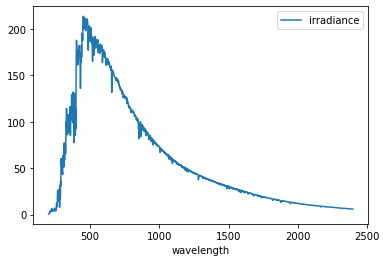

In [4]:
F0 = pd.read_csv('https://oceancolor.gsfc.nasa.gov/docs/rsr/f0.txt',  encoding='iso-8859-1', sep=r'\s{1,}', 
                 skiprows=15, names= ['wavelength', 'irradiance'], index_col='wavelength', engine='python')
F0.plot()


# Rrs = LwN/F0 where LwN is the normalized water leaving radiance and F0 is the extra-terrestrial solar irradiation (both are spectral)
$Lwn => \frac{mW}{cm^2 \ sr \ nm} \quad \textrm{and} \quad F0 => \frac{uW}{cm^2 \ nm}$

$Rrs = \frac{Lwn}{F0} => \frac{mW}{cm^2 \ sr \ nm} \times \frac{cm^2 \ nm}{uW} \times \frac{1000 uW}{mW} = \frac{1}{sr}$

F0[709nm]=0.139646 mW


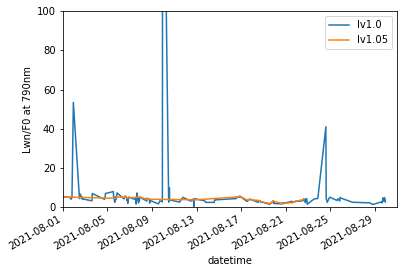

In [8]:
#lv1
F0_709 = F0.loc[709].values/1000
(df['Lwn[709nm]']/F0_709).plot(label='lv1.0').legend()
#lv1.5
(df2['Lwn[709nm]']/F0_709).plot(label='lv1.05').legend()
plt.xlim(pd.to_datetime('2021-08-01'), pd.to_datetime('2021-08-31'))
plt.ylim(0, 100)
plt.ylabel('Lwn/F0 at 790nm')
print(r'F0[709nm]=%f mW' % F0_709)

In [6]:
def calc_Rrs(LwN, F0):
    return LwN/F0

def calc_CI(Rrs681, Rrs667, Rrs709):
    return -(Rrs681 - Rrs667 - (Rrs709 - Rrs667)*((681-664)/(709-664)))

def load_F0():
    return pd.read_csv('../seaprism/f0.txt', skiprows=15, sep='\t', index_col='wavelength')

def get_CI(df):
    ## CI = -(Rrs681 - Rrs667 - (Rrs709 - Rrs667)*((681-664)/(709-664)));
    wls = [667, 681, 709]
    F0 = load_F0()
    for wl in wls:
        Rrs_name = 'Rrs[%snm]' % wl
        if Rrs_name not in df.columns:
            df[Rrs_name] = calc_Rrs(df['Lwn[%snm]' % str(wl)], F0.loc[wl].values)
    return calc_CI(df['Rrs[681nm]'], df['Rrs[667nm]'], df['Rrs[709nm]'])

(0.0, 0.1)

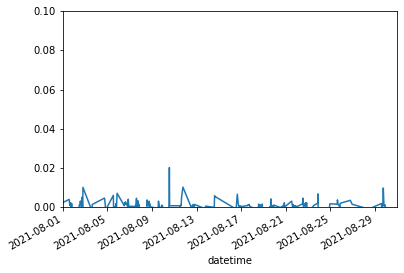

In [7]:
CI = get_CI(df)
CI.plot()
plt.xlim(pd.to_datetime('2021-08-01'), pd.to_datetime('2021-08-31'))
plt.ylim(0, .1)